In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.cluster import KElbowVisualizer
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/water-potability/water_potability.csv")

In [3]:
df.sample(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
1921,7.288737,233.977810,31617.075415,8.533888,331.838167,490.047095,12.225342,31.802024,3.531385,1
2594,8.849703,197.779047,20129.358792,5.182436,329.502104,356.476723,11.882861,45.706793,2.987672,0
227,7.083779,112.820254,8580.245561,4.210284,234.852699,434.747715,23.399516,94.160307,3.887681,0
1881,6.832217,164.274393,14015.044769,6.055985,281.678040,389.978097,14.836637,44.367574,3.145416,0
626,5.548182,204.259899,39997.783697,7.027226,319.202935,431.972429,15.400396,41.952292,3.945460,0


In [4]:
print("<**********************************Decsribe**********************************>")
print("")
print(df.describe())
print("")
print("<**********************************Info**********************************>")
print("")
print(df.info())
print("")
print("<**********************************Columns**********************************>")
print("")
print(df.columns)
print("<**********************************Null**********************************>")
print("")
print(df.isnull().sum())

<**********************************Decsribe**********************************>

                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
s

# Boş verilerin doldurulması 

In [5]:
df['ph'].fillna(value = df['ph'].mean(), inplace = True)
df['Sulfate'].fillna(value = df['Sulfate'].mean(), inplace = True)
df['Trihalomethanes'].fillna(value = df['Trihalomethanes'].mean(), inplace = True)

In [6]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

# Görselleştirmeler

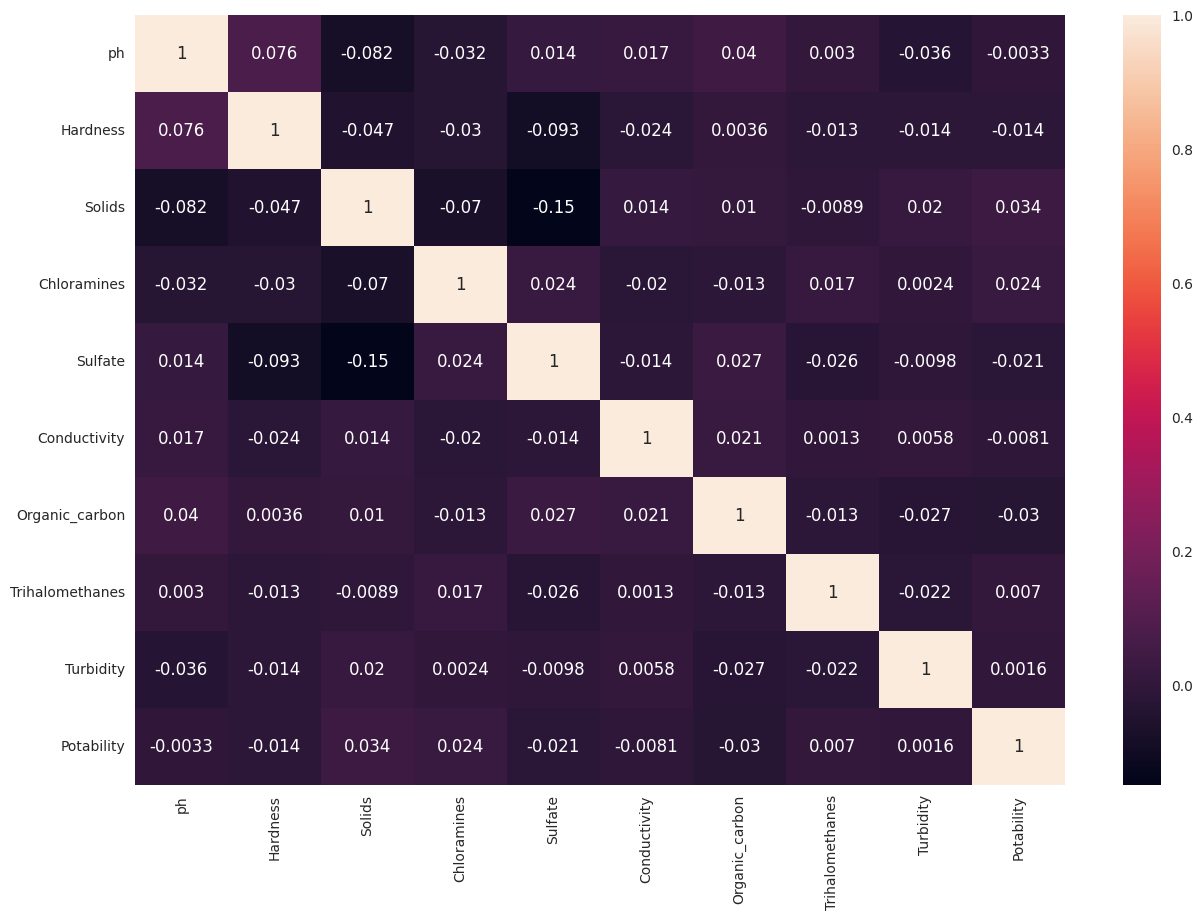

In [7]:
corr = df.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr,annot=True)
plt.show()

In [8]:
Potability_Counts = pd.DataFrame(df['Potability'].value_counts())

fig = px.pie(Potability_Counts, values= 'count', names = ["İçilemez", "İçilebilir"], hole = 0.35, opacity = 0.7,
            labels = {"label" :"Potability","Potability":"Number of Samples"})
fig.update_layout(title = dict(text = "İçilebilirlik Stününün Dağılım Grafiği"))
fig.update_traces(textposition = "outside", textinfo = "percent+label")
fig.show()

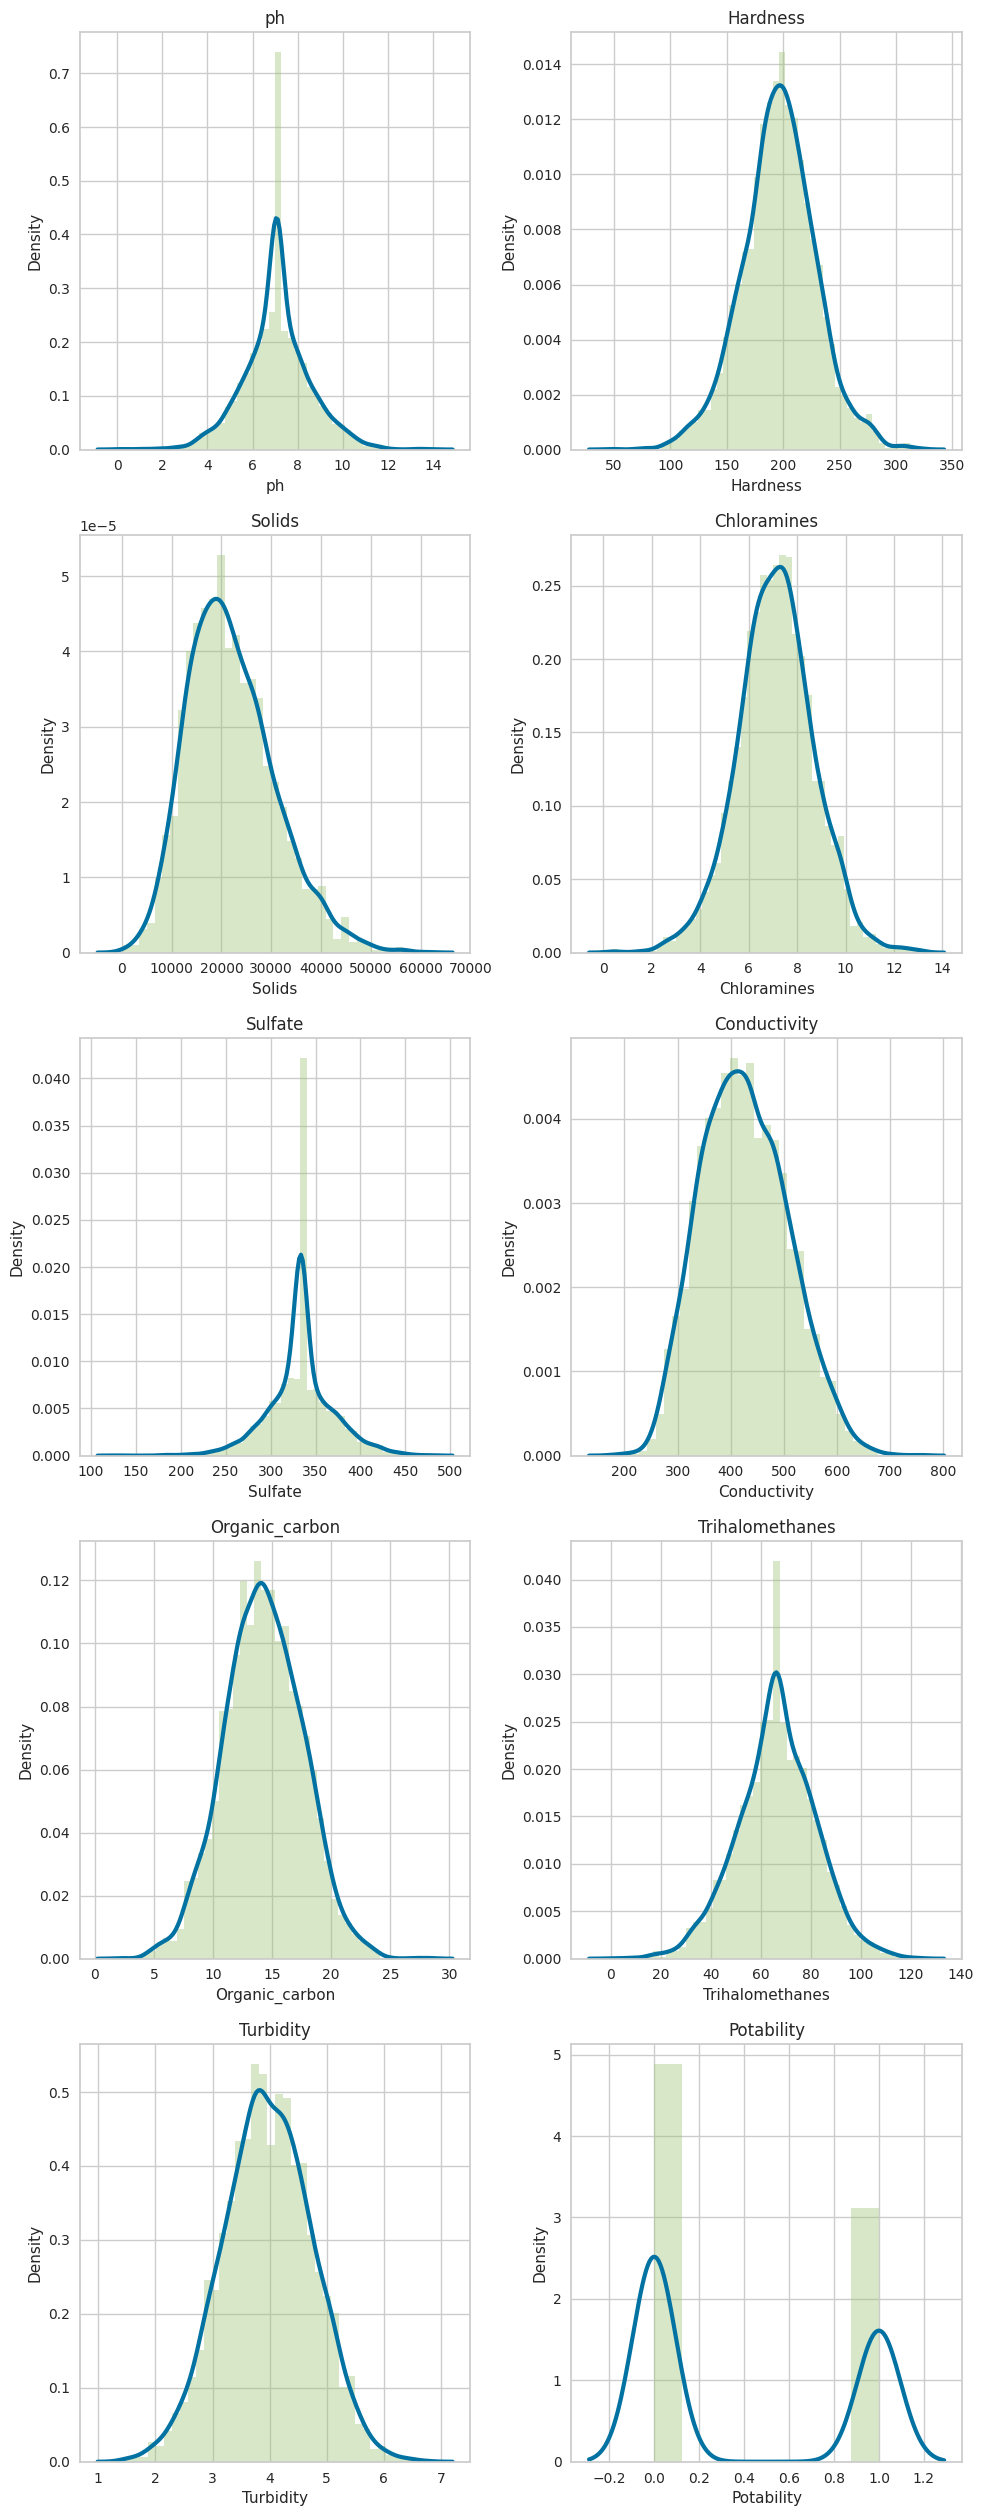

In [9]:
# 2 sütunlu ve yeterli sayıda satırı olan bir figür oluşturma
# 17 özellik için 9 satıra ihtiyacımız var (17 özellik / 2 sütun yukarı yuvarlandığında)
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(10, 45))

# Eksen dizisini düzleştirmek
axes = axes.flatten()

# Her özellik ve ilgili eksen için döngü
for i, column in enumerate(df.columns):
    sns.distplot(df[column], kde_kws={"color": "b", "lw": 3, "label": "KDE"}, hist_kws={"color": "g"}, ax=axes[i])
    axes[i].set_title(column)

# Boş alt grafikleri kaldırma
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

*Yeşil çubuklar histogramı, mavi çizgi ise çekirdek yoğunluk tahminini (KDE) temsil etmektedir. KDE, belirli bir değer aralığındaki veri yoğunluğunun sürekli bir tahminidir. Histogram, ise belirli aralıklardaki gözlem sayısını gösteren çubuklar ile ayrık bir dağılımı temsil eder.*

# CLUSTERNING

In [10]:
# Verlierin Ölçeklendirilmesi
scaler = StandardScaler()
df_scaled= scaler.fit_transform(df)
df_scaled

array([[-6.04313345e-16,  2.59194711e-01, -1.39470871e-01, ...,
         1.30614943e+00, -1.28629758e+00, -7.99774743e-01],
       [-2.28933938e+00, -2.03641367e+00, -3.85986650e-01, ...,
        -6.38479983e-01,  6.84217891e-01, -7.99774743e-01],
       [ 6.92867789e-01,  8.47664833e-01, -2.40047337e-01, ...,
         1.50940884e-03, -1.16736546e+00, -7.99774743e-01],
       ...,
       [ 1.59125368e+00, -6.26829230e-01,  1.27080989e+00, ...,
         2.18748247e-01, -8.56006782e-01,  1.25035206e+00],
       [-1.32951593e+00,  1.04135450e+00, -1.14405809e+00, ...,
         7.03468419e-01,  9.50797383e-01,  1.25035206e+00],
       [ 5.40150905e-01, -3.85462310e-02, -5.25811937e-01, ...,
         7.80223466e-01, -2.12445866e+00,  1.25035206e+00]])

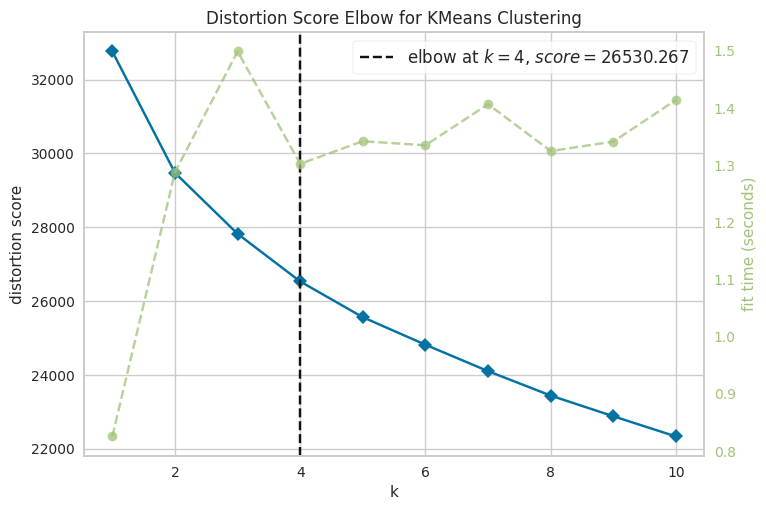

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
# KMeans oluşturma
km = KMeans()

# KMeans modeli ve keşfedilecek küme sayısı aralığı ile KElbowVisualizer'ı örnekleme
visualizer = KElbowVisualizer(km, k=(1, 11))

# Veriyi görselleştiriciye fit etme
visualizer.fit(df_scaled)

# Şekli (figürü) sonlandıralım ve gösterelim
visualizer.show()

In [12]:
kmeans = KMeans(4)
labels = kmeans.fit_predict(df_scaled)

In [13]:
data = kmeans.cluster_centers_

In [14]:
cluster_centers = pd.DataFrame(data,columns = [df.columns])
cluster_centers

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.264243,-0.098206,0.986455,-0.200396,-1.015161,0.068872,-0.131840,0.077387,0.034720,1.137660
1,-0.148109,0.031390,-0.441030,0.145869,0.486776,-0.063226,0.021810,-0.022303,-0.012957,1.250352
2,0.630407,0.217189,-0.360221,-0.344455,0.192893,0.169616,0.059711,0.052909,-0.216906,-0.795836
3,-0.705147,-0.220164,0.292901,0.356086,-0.132421,-0.167875,-0.019120,-0.078389,0.235658,-0.797580


In [15]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers, columns=[df.columns])
cluster_centers

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.469161,193.141008,30662.569661,6.805082,297.090806,431.770773,13.848889,67.616486,3.993877,0.945032
1,6.863115,197.401431,18147.484236,7.353165,351.366430,421.095678,14.357111,66.044625,3.956676,1.000000
2,8.007324,203.509519,18855.949722,6.577059,340.746385,439.912060,14.482474,67.230536,3.797542,0.001921
3,6.044418,189.131668,24582.024687,7.685906,328.990473,412.638856,14.221729,65.160299,4.150662,0.001071


In [16]:
df_cluster = pd.concat([df,pd.DataFrame({'cluster':labels})],axis=1)
df_cluster.sample(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,cluster
1881,6.832217,164.274393,14015.044769,6.055985,281.678040,389.978097,14.836637,44.367574,3.145416,0,2
1396,10.202972,211.963404,21708.949286,7.491895,333.775777,395.140783,21.520593,62.659460,3.270904,0,2
2877,9.871791,114.371450,27912.908263,8.660269,340.046298,490.451835,8.517762,64.831248,3.652264,0,2
733,9.239440,212.569076,14829.624212,7.172920,324.128915,575.421968,16.581120,66.885270,3.471971,1,1
193,9.320305,129.823859,16002.138320,4.405035,271.670562,499.844167,13.076859,82.837583,4.205810,0,2


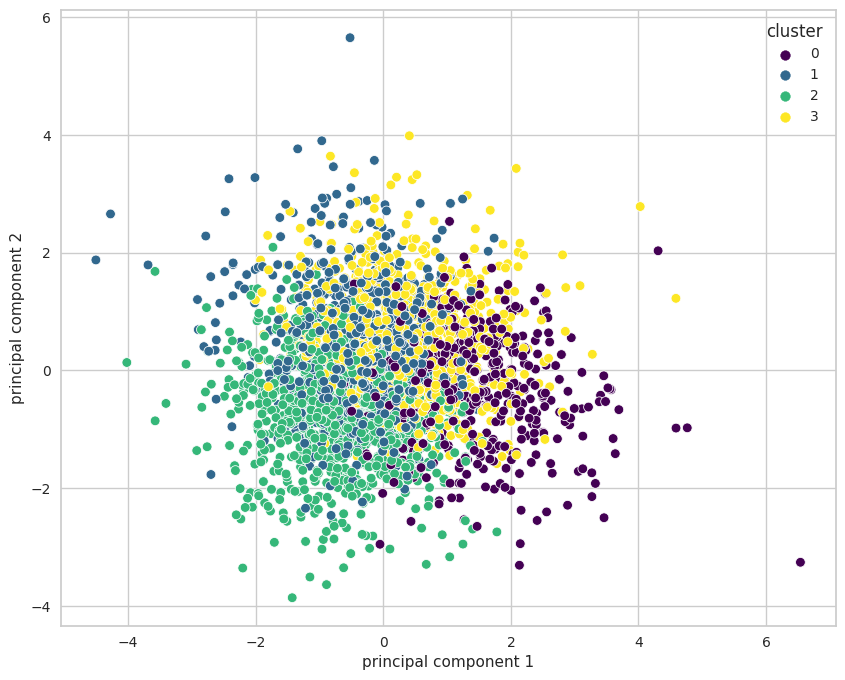

In [17]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_scaled)
principalDf = pd.DataFrame(principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['cluster'] = df_cluster['cluster']
plt.figure(figsize=(10,8))
sns.scatterplot(data=principalDf, x='principal component 1', y='principal component 2', hue='cluster', palette='viridis')
plt.show()

In [18]:
# t-SNE'yi üç boyutlu olarak uygulama
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(df_scaled)

# t-SNE sonuçlarını ve etiketleri Plotly 3D scatter plot'a aktarın
fig = go.Figure()

# Her bir küme için bir iz ekleme
for cluster_id in np.unique(labels):
    cluster_indices = labels == cluster_id
    fig.add_trace(go.Scatter3d(
        x=tsne_results[cluster_indices, 0],
        y=tsne_results[cluster_indices, 1],
        z=tsne_results[cluster_indices, 2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.8,
        ),
        name=f'Cluster {cluster_id}'
    ))

# 3D grafik için düzeni güncelleme
fig.update_layout(
    title='3D t-SNE Visualization',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Grafik gösterimi
fig.show()

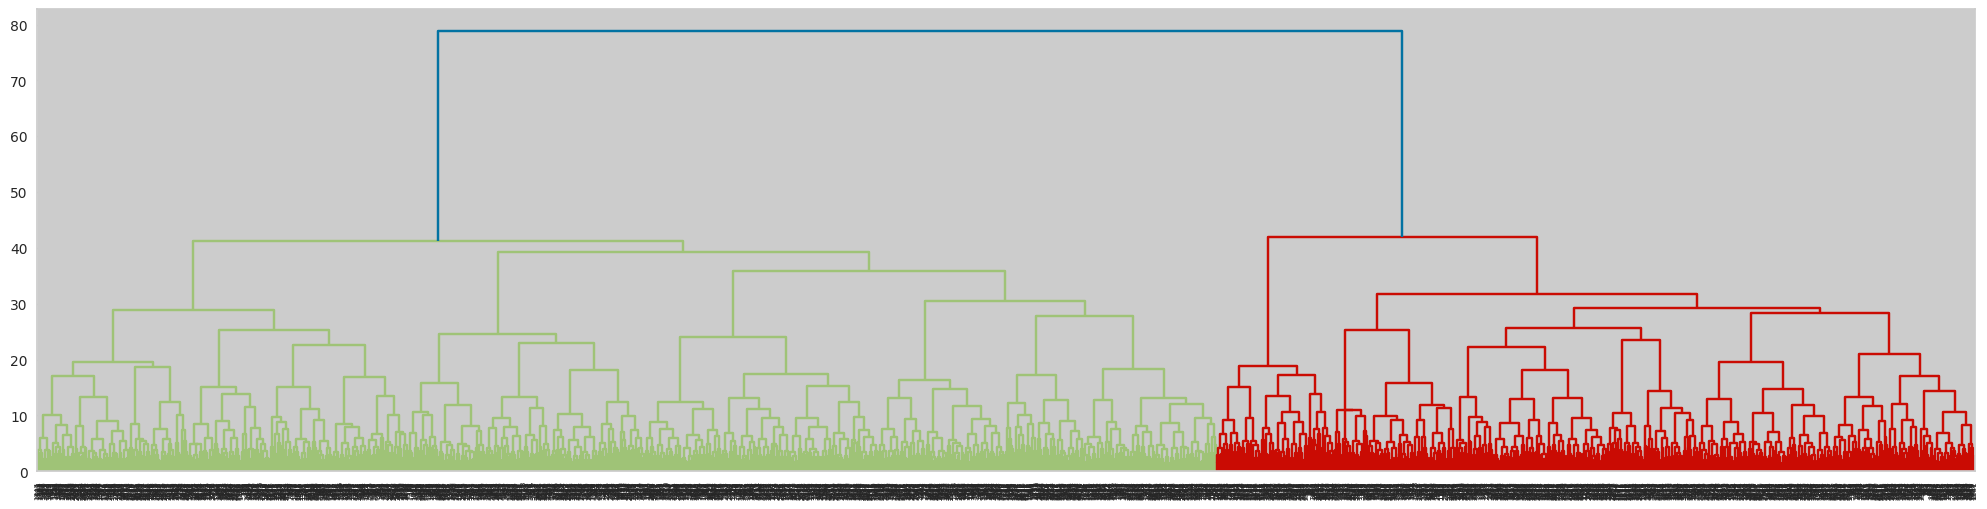

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage
dendrogram_data =linkage(df_scaled,method='ward',metric='euclidean') #ward optimizasyon

plt.figure(figsize=(25,6))
dendrogram(dendrogram_data);

# Clasification

In [20]:
# İstenen dereceyle PolynomialFeatures'ı başlatın
poly = PolynomialFeatures(degree=2, include_bias=False)

# Seçilen özellikleri dönüştürün
poly_ozellikler = poly.fit_transform(df[['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate']])

# Özel özellik adlarıyla bir DataFrame oluşturun
#poly_ozellik_adlari = poly.get_feature_names_out(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate'])
poly_feature_names = ['poly_' + col for col in poly.get_feature_names_out(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate'])]

poly_ozellikler_df= pd.DataFrame(poly_ozellikler, columns=poly_feature_names)
#poly_ozellikler_df = pd.DataFrame(poly_ozellikler, columns=['poly_' + str(col) for col in poly_ozellik_adlari])

# poly_ozellikler_df şimdi polinom özellikleri içerir ve her bir sonuç özelliği için orijinal özellik adlarına dayalı özel adlar sağlar.
poly_ozellikler_df.columns

Index(['poly_ph', 'poly_Hardness', 'poly_Solids', 'poly_Chloramines',
       'poly_Sulfate', 'poly_ph^2', 'poly_ph Hardness', 'poly_ph Solids',
       'poly_ph Chloramines', 'poly_ph Sulfate', 'poly_Hardness^2',
       'poly_Hardness Solids', 'poly_Hardness Chloramines',
       'poly_Hardness Sulfate', 'poly_Solids^2', 'poly_Solids Chloramines',
       'poly_Solids Sulfate', 'poly_Chloramines^2', 'poly_Chloramines Sulfate',
       'poly_Sulfate^2'],
      dtype='object')

In [21]:
df_poly = df.join(poly_ozellikler_df)

In [22]:
df_poly.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability',
       'poly_ph', 'poly_Hardness', 'poly_Solids', 'poly_Chloramines',
       'poly_Sulfate', 'poly_ph^2', 'poly_ph Hardness', 'poly_ph Solids',
       'poly_ph Chloramines', 'poly_ph Sulfate', 'poly_Hardness^2',
       'poly_Hardness Solids', 'poly_Hardness Chloramines',
       'poly_Hardness Sulfate', 'poly_Solids^2', 'poly_Solids Chloramines',
       'poly_Solids Sulfate', 'poly_Chloramines^2', 'poly_Chloramines Sulfate',
       'poly_Sulfate^2'],
      dtype='object')

In [23]:
df_poly

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,...,poly_Hardness^2,poly_Hardness Solids,poly_Hardness Chloramines,poly_Hardness Sulfate,poly_Solids^2,poly_Solids Chloramines,poly_Solids Sulfate,poly_Chloramines^2,poly_Chloramines Sulfate,poly_Sulfate^2
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0,...,41980.098743,4.259943e+06,1495.743736,75505.501517,4.322789e+08,151781.033682,7.661943e+06,53.293093,2690.248101,135804.367545
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0,...,16750.292355,2.411156e+06,858.752901,43198.235806,3.470791e+08,123615.014718,6.218262e+06,44.026488,2214.684348,111406.269052
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0,...,50281.900027,4.464441e+06,2079.989442,74844.631623,3.963899e+08,184678.591692,6.645323e+06,86.042017,3096.065253,111406.269052
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0,...,45955.952092,4.720163e+06,1727.706436,76506.892200,4.848107e+08,177453.744580,7.858068e+06,64.952838,2876.263988,127367.713814
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0,...,32797.756648,3.256022e+06,1185.599136,56166.050134,3.232439e+08,117701.231503,5.575926e+06,42.857971,2030.334611,96184.175690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1,...,37512.614657,9.215569e+06,1388.047067,69715.464565,2.263951e+09,340995.787013,1.712671e+07,51.360714,2579.621468,129562.976189
3272,7.808856,193.553212,17329.802160,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1,...,37462.845739,3.354239e+06,1560.302503,64603.373533,3.003220e+08,139701.808390,5.784268e+06,64.985557,2690.687358,111406.269052
3273,9.419510,175.762646,33155.578218,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1,...,30892.507833,5.827512e+06,1291.896444,58665.313767,1.099292e+09,243701.232887,1.106653e+07,54.025929,2453.329806,111406.269052
3274,5.126763,230.603758,11983.869376,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1,...,53178.092977,2.763525e+06,1453.577702,76969.948252,1.436131e+08,75538.601339,3.999925e+06,39.732304,2103.907722,111406.269052


In [24]:
x = df_poly.drop(["Potability"],axis=1)
y = df_poly["Potability"]

In [25]:
x.columns, x.shape

(Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
        'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'poly_ph',
        'poly_Hardness', 'poly_Solids', 'poly_Chloramines', 'poly_Sulfate',
        'poly_ph^2', 'poly_ph Hardness', 'poly_ph Solids',
        'poly_ph Chloramines', 'poly_ph Sulfate', 'poly_Hardness^2',
        'poly_Hardness Solids', 'poly_Hardness Chloramines',
        'poly_Hardness Sulfate', 'poly_Solids^2', 'poly_Solids Chloramines',
        'poly_Solids Sulfate', 'poly_Chloramines^2', 'poly_Chloramines Sulfate',
        'poly_Sulfate^2'],
       dtype='object'),
 (3276, 29))

In [26]:
# Eğitim ve test setlerini ayırma
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Regresyon modeli oluşturma
#rf= RandomForestClassifier(max_depth=15, min_samples_leaf=4)
#rf= RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=5,n_estimators=300)
rf= RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=300)   

In [28]:
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=300)

In [29]:
tahmin=rf.predict(x_test)

In [30]:
# Modeli eğitim verileri ile eğitme
model = rf.fit(x_train,y_train)

In [31]:
# Test verileri üzerinde tahmin yapma
prediction = model.predict(x_test)

In [32]:
accuracy_score(y_test,tahmin)

0.6951219512195121

In [33]:
# Hiperparametre ayarlama (Grid Search) - Bu kısım zaman alıcı olabilir.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(x_train, y_train)  

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.3

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [34]:
# En iyi hiperparametreleri bulma ve kullanma
best_params = grid_search.best_params_
rf_classifier_best = RandomForestClassifier(**best_params)
rf_classifier_best.fit(x_train, y_train)
y_pred_best = rf_classifier_best.predict(x_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

In [35]:
rf_classifier_best

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=300)

In [36]:
accuracy_best

0.6966463414634146

In [37]:
# Yeni veri noktası için özellikler
yeni_su_ornegi = {
    'ph': [7.0],
    'Hardness': [200],
    'Solids': [10000],
    'Chloramines': [8],
    'Sulfate': [300],
    'Conductivity': [400],
    'Organic_carbon': [10],
    'Trihalomethanes': [70],
    'Turbidity': [3.5]
}

# DataFrame'e dönüştürme
yeni_su_df = pd.DataFrame(yeni_su_ornegi)
#yeni_su_df = df.iloc[:1].drop(columns=["Potability"])
# İstenen dereceyle PolynomialFeatures'ı başlatma
poly = PolynomialFeatures(degree=2, include_bias=False)

# Seçilen özellikleri dönüştürme
poly_ozellikler = poly.fit_transform(yeni_su_df[['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate']])

# Özel özellik adlarıyla bir DataFrame oluşturma
poly_ozellik_adlari = poly.get_feature_names_out(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate'])
poly_ozellikler_df = pd.DataFrame(poly_ozellikler, columns=['poly_' + str(col) for col in poly_ozellik_adlari])

# poly_ozellikler_df şimdi polinom özellikleri içerir ve her bir sonuç özelliği için orijinal özellik adlarına dayalı özel adlar sağlar.

# Yeni polinom özellikleri ile orijinal DataFrame'i birleştirme
yeni_su_df_extended = yeni_su_df.join(poly_ozellikler_df)

yeni_su_df_extended.columns, yeni_su_df_extended.shape

(Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
        'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'poly_ph',
        'poly_Hardness', 'poly_Solids', 'poly_Chloramines', 'poly_Sulfate',
        'poly_ph^2', 'poly_ph Hardness', 'poly_ph Solids',
        'poly_ph Chloramines', 'poly_ph Sulfate', 'poly_Hardness^2',
        'poly_Hardness Solids', 'poly_Hardness Chloramines',
        'poly_Hardness Sulfate', 'poly_Solids^2', 'poly_Solids Chloramines',
        'poly_Solids Sulfate', 'poly_Chloramines^2', 'poly_Chloramines Sulfate',
        'poly_Sulfate^2'],
       dtype='object'),
 (1, 29))

In [38]:
yeni_su_df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.0,200,10000,8,300,400,10,70,3.5


In [39]:
x.columns, x.shape

(Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
        'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'poly_ph',
        'poly_Hardness', 'poly_Solids', 'poly_Chloramines', 'poly_Sulfate',
        'poly_ph^2', 'poly_ph Hardness', 'poly_ph Solids',
        'poly_ph Chloramines', 'poly_ph Sulfate', 'poly_Hardness^2',
        'poly_Hardness Solids', 'poly_Hardness Chloramines',
        'poly_Hardness Sulfate', 'poly_Solids^2', 'poly_Solids Chloramines',
        'poly_Solids Sulfate', 'poly_Chloramines^2', 'poly_Chloramines Sulfate',
        'poly_Sulfate^2'],
       dtype='object'),
 (3276, 29))

In [40]:
# Modeli kullanarak tahmin yap
tahmin = model.predict(yeni_su_df_extended)
tahmin_sonucu = 'İçilebilir' if tahmin[0] == 1 else 'İçilemez'
tahmin_sonucu

'İçilemez'